In [22]:
from gp_diffscales_withavgloss_fixkernel_trueavg import *
%load_ext autoreload
%autoreload 2
import os

# 1. Generate synthetic data
N, D, T, K, P = 100, 5, 50, 3, 5  # Example dimensions
sim_data = generate_synthetic_data(N, D, T, K, P, return_true_params=True)

# 2. Compute smoothed prevalence
prevalence_t = compute_smoothed_prevalence(sim_data['Y'], window_size=5)
modelold = AladynSurvivalFixedKernelsAvgLoss(
    N=N, D=D, T=T, K=K, P=P,
    G=sim_data['G'],
    Y=sim_data['Y'],
    prevalence_t=prevalence_t
)

# 4. Fit model
history = modelold.fit(
    event_times=sim_data['event_times'],
    num_epochs=1000,
    learning_rate=1e-3,
    lambda_reg=1e-2
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Epoch 0, Loss: 167.7474
Epoch 100, Loss: 41.7156
Epoch 200, Loss: 35.2758
Epoch 300, Loss: 34.0571
Epoch 400, Loss: 33.2389
Epoch 500, Loss: 32.5650
Epoch 600, Loss: 31.9759
Epoch 700, Loss: 31.4374
Epoch 800, Loss: 30.9318
Epoch 900, Loss: 30.4519


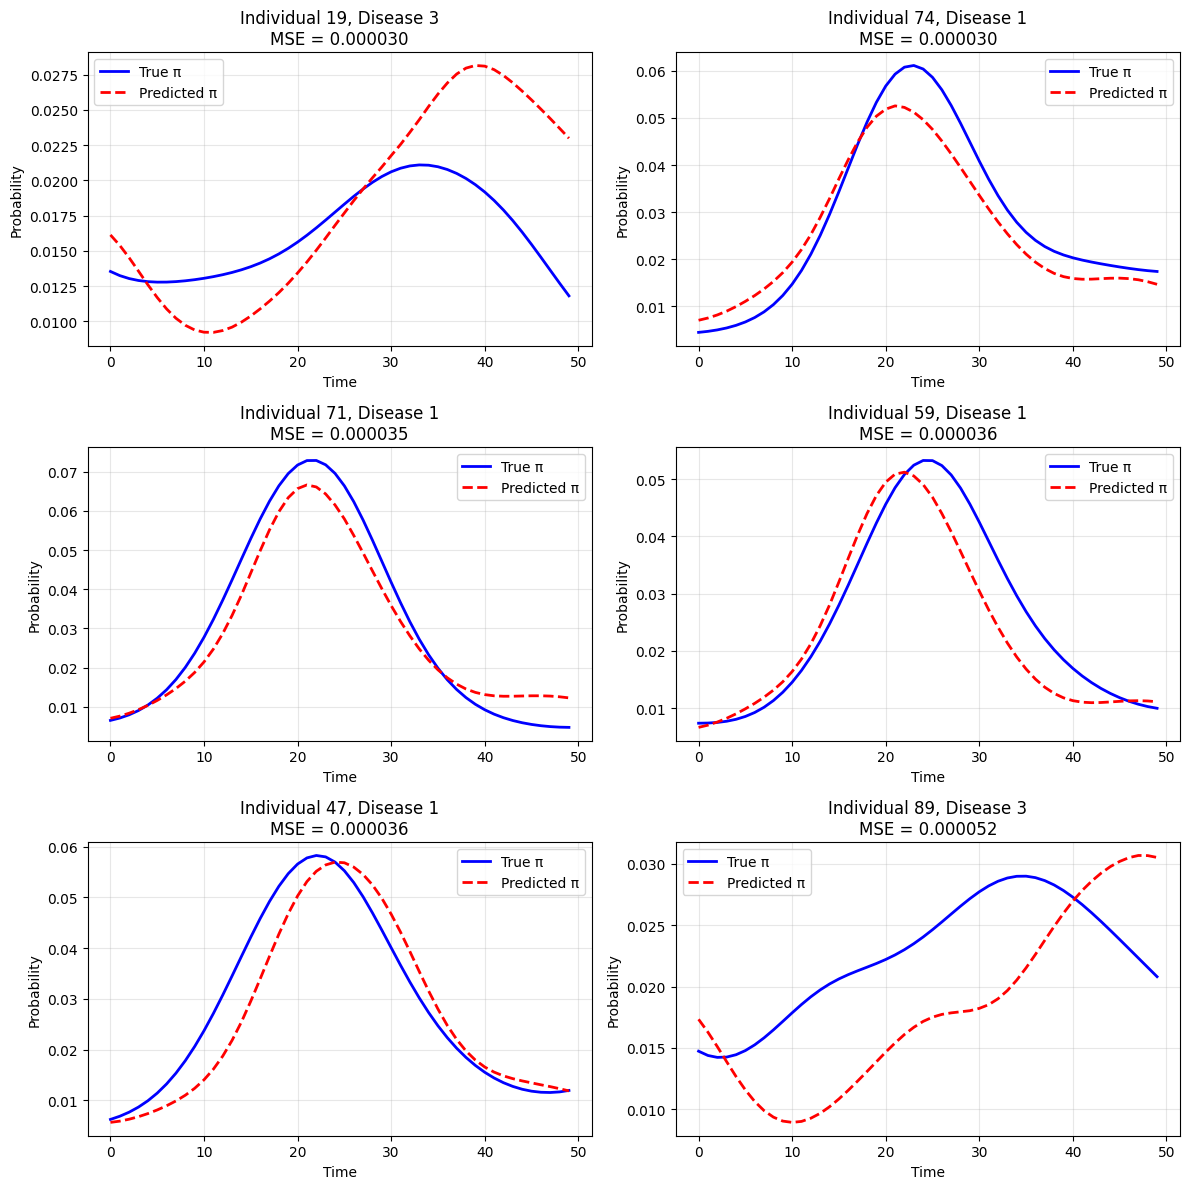

In [23]:
plot_best_matches(sim_data['pi'], modelold.forward()[0], n_samples=6)

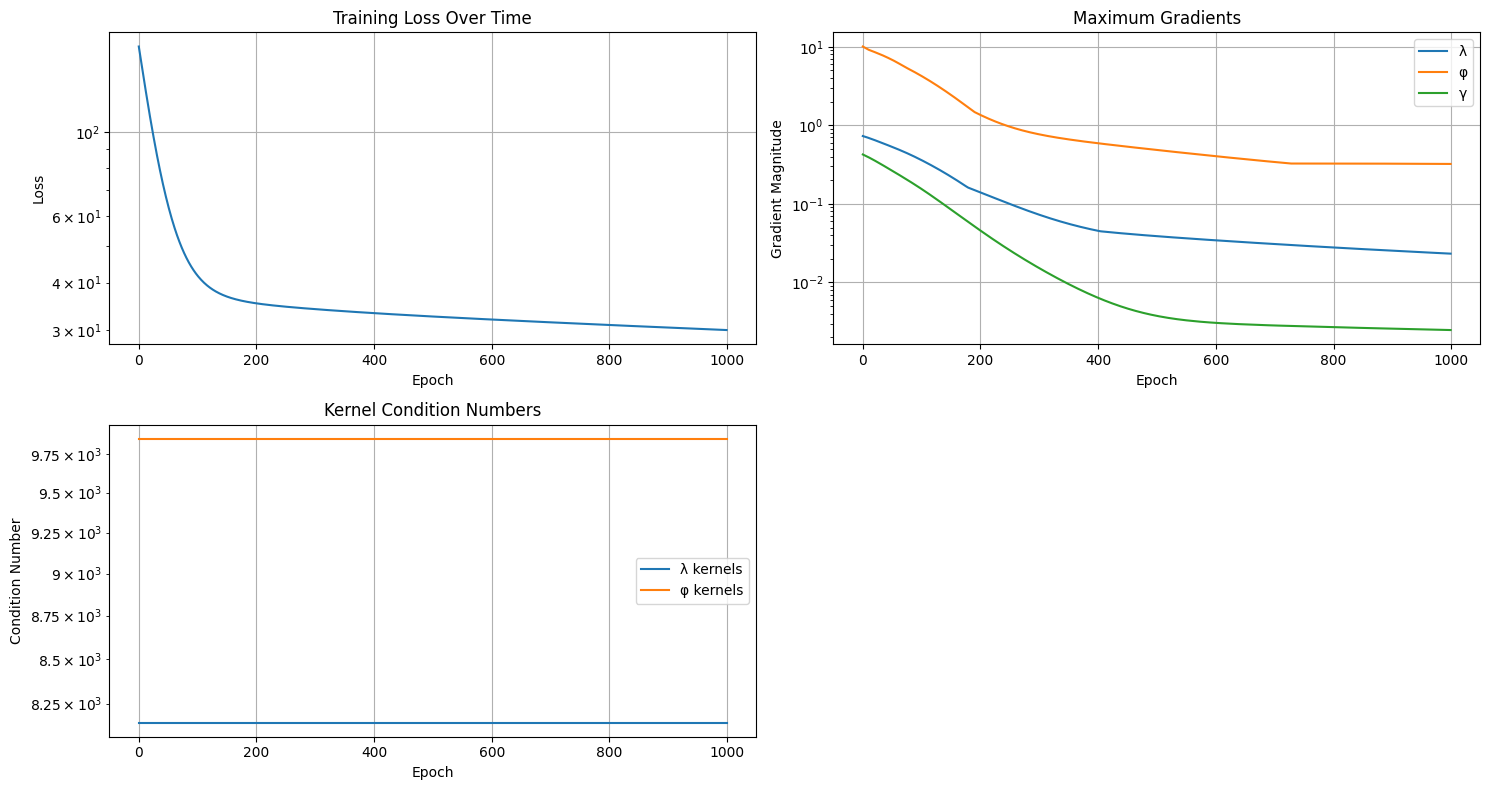

In [24]:
# 5. Plot diagnostics
plot_training_diagnostics(history)

In [60]:
import os
import sys
sys.path.append('/Users/sarahurbut/aladynoulli/pyScripts/otherimps/')

# Import the correct model
from gp_softmax_torch_works_play_matrprev2 import AladynSurvivalModel


Help on class AladynSurvivalModel in module gp_softmax_torch_works_play_matrprev2:

class AladynSurvivalModel(torch.nn.modules.module.Module)
 |  AladynSurvivalModel(N, D, T, K, P, G, Y, prevalence_t)
 |  
 |  Method resolution order:
 |      AladynSurvivalModel
 |      torch.nn.modules.module.Module
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, N, D, T, K, P, G, Y, prevalence_t)
 |      Initialize internal Module state, shared by both nn.Module and ScriptModule.
 |  
 |  compute_gp_prior_loss(self)
 |      Compute the GP prior loss with time-dependent mean
 |  
 |  compute_loss(self, event_times)
 |      Compute the negative log-likelihood loss for survival data.
 |  
 |  fit(self, event_times, num_epochs=1000, learning_rate=0.001, lambda_reg=0.01, convergence_threshold=0.01, patience=10)
 |      Fit model with early stopping and parameter monitoring
 |      
 |      Args:
 |          event_times: Tensor of event times
 |          num_epochs: Maximum n

In [61]:
K=3

modeloldest = AladynSurvivalModel(
    N=N, D=D, T=T, K=K, P=P,
    G=sim_data['G'],
    Y=sim_data['Y'],
    prevalence_t=prevalence_t
)


In [62]:

# 4. Fit model
history = modeloldest.fit(
    event_times=sim_data['event_times'],
    num_epochs=1000,
    learning_rate=1e-3,
    lambda_reg=1e-2
)


Epoch 0
Loss: 9658.1025
Length scales: [16.665667 16.665667 16.665667]
Amplitudes: [1.0010005 1.0010005 1.0010005]
Max gradients - λ: 59.7194, φ: 71.0316, γ: 30.9089
Mean condition number: 9847.14
Loss change: inf

Epoch 100
Loss: 2442.2583
Length scales: [16.562204 16.562037 16.562233]
Amplitudes: [1.1172639 1.1169816 1.1169417]
Max gradients - λ: 15.9296, φ: 17.0018, γ: 6.4713
Mean condition number: 6107.39
Loss change: 6.5557

Epoch 200
Loss: 2167.3105
Length scales: [16.470444 16.470947 16.471443]
Amplitudes: [1.2490674 1.2478292 1.2476122]
Max gradients - λ: 4.6265, φ: 6.7205, γ: 0.7265
Mean condition number: 7600.41
Loss change: 1.4819

Epoch 300
Loss: 2049.6033
Length scales: [16.391962 16.393343 16.395393]
Amplitudes: [1.3904556 1.3877536 1.3871301]
Max gradients - λ: 1.3030, φ: 5.7107, γ: 0.3680
Mean condition number: 9378.75
Loss change: 0.9548

Epoch 400
Loss: 1967.2133
Length scales: [16.320786 16.323837 16.328594]
Amplitudes: [1.5445935 1.5397985 1.5388776]
Max gradients 

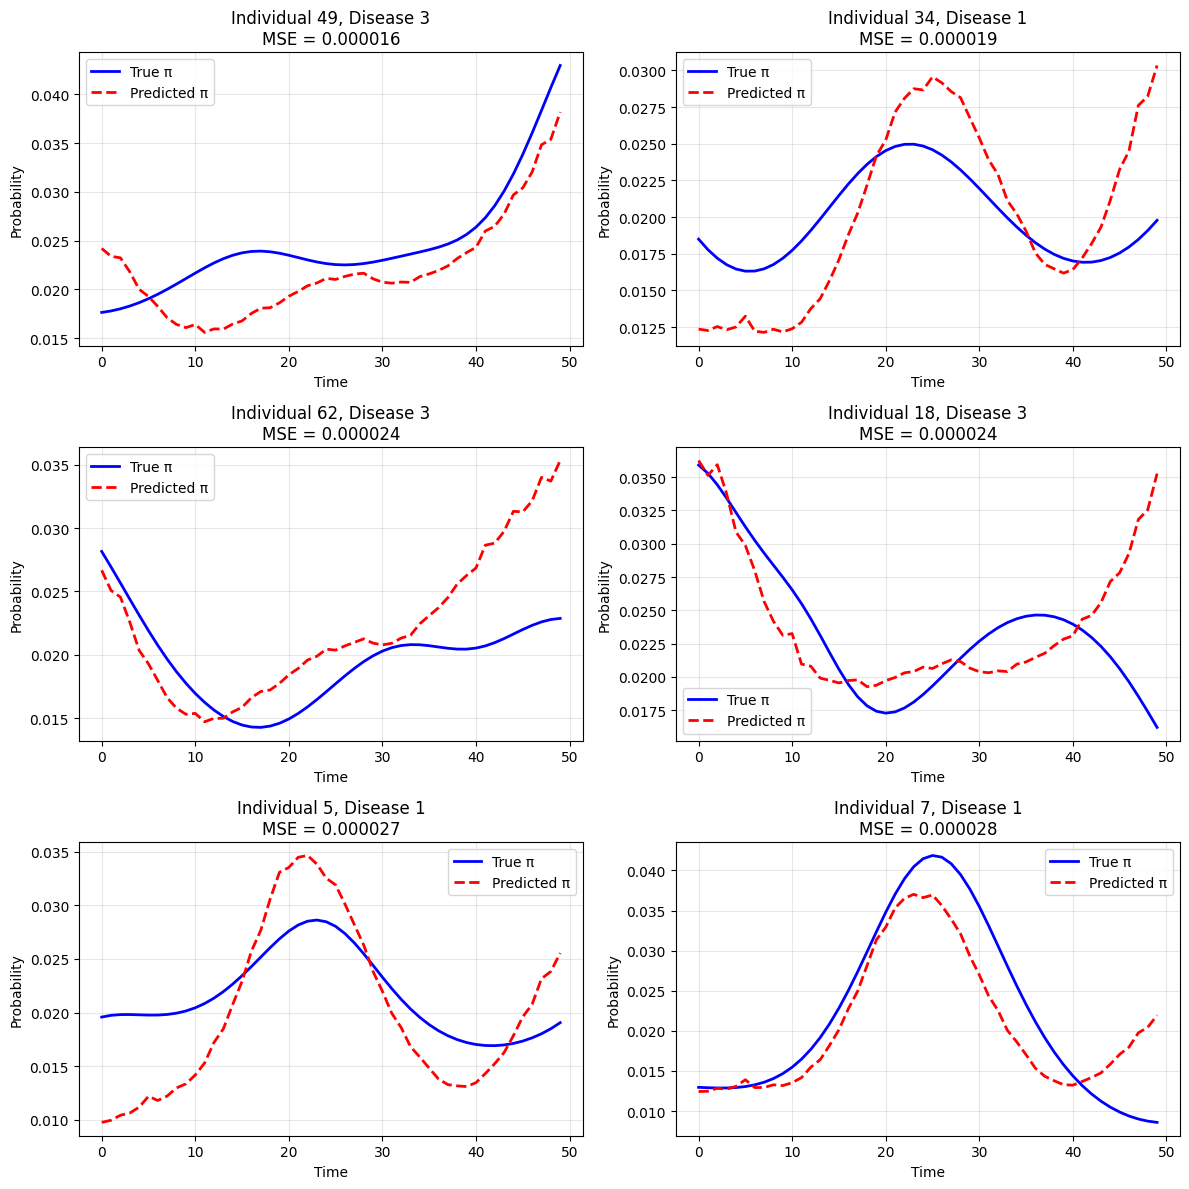

In [63]:
plot_best_matches(sim_data['pi'], modeloldest.forward()[0], n_samples=6)

In [64]:
sim_data['length_scales']

array([16.38209535, 16.16919643, 14.13048539])

In [ ]:
import rpy2.robjects as robjects
import numpy as np
import os as os
from rpy2.robjects import numpy2ri
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2
# Specify the path to your data files
data_path = "/Users/sarahurbut/tensornoulli_ehr_new/data"

# Activate automatic conversion between R and NumPy arrays
numpy2ri.activate()# Load data saved as .rds files
Y = np.array(robjects.r['readRDS'](os.path.join(data_path, 'Y.rds')))
E = np.array(robjects.r['readRDS'](os.path.join(data_path, 'event_for_aladynoulli.rds')))
G = np.array(robjects.r['readRDS'](os.path.join(data_path, 'prs.rds')))

E = E.astype(int)

# G should be float64
G = G.astype(float)
G.shape
G = G.T
print("G shape after transposition:", G.shape)

# Convert to PyTorch tensors
Y_tensor = torch.FloatTensor(Y)
E_tensor = torch.FloatTensor(E)
G_tensor = torch.FloatTensor(G)

# Get dimensions
N, D, T = Y_tensor.shape
P = G_tensor.shape[1]
T = int(E_tensor.max() + 1)  # 0-indexed time
K = 10  # number of topics

# Print shapes to verify
print("Tensor shapes:")
print(f"Y: {Y_tensor.shape}")  # [N, D]
print(f"E: {E_tensor.shape}")  # [N, D]
print(f"G: {G_tensor.shape}")  # [N, P]
print(f"Time range: 0 to {T-1}")
print(T)
print(K)


import rpy2.robjects as robjects
import pandas as pd
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Load the metadata from R
disease_names = pd.DataFrame(robjects.r['readRDS']('/Users/sarahurbut/Dropbox (Personal)/disease_names.rds'))
prs_names = pd.DataFrame(robjects.r['readRDS']('/Users/sarahurbut/Dropbox (Personal)/prs_names.rds'))
disease_names_list = disease_names[0].tolist()

In [2]:
from cluster_g import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import

In [ ]:
prevalence_t=compute_smoothed_prevalence(Y=Y,window_size=5)
K=20
# Create model
model = AladynSurvivalFixedKernelsAvgLoss_clust(N, D, T, K, P, G, Y, prevalence_t)



# Visualize the clusters
model.visualize_clusters(disease_names_list)

In [ ]:
model = AladynSurvivalFixedKernelsAvgLoss_clust(N, D, T, K, P, G, Y, prevalence_t,disease_names_list)
model.print_cluster_memberships()
model.plot_initial_params()

In [ ]:
model.visualize_initialization()
model.psi

In [ ]:
Y_tensor.shape

In [ ]:
# Initialize model
model = AladynSurvivalFixedKernelsAvgLoss_clust(N, D, T, K, P, G, Y, prevalence_t, disease_names_list)

# Store initial psi values
initial_psi = model.psi.detach().clone()


history = model.fit(E_tensor, num_epochs=1000, learning_rate=1e-4, lambda_reg=1e-2)

# Compare final vs initial psi
print("\nOverall psi changes:")

In [ ]:
import matplotlib.pyplot as plt

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot loss
ax1.plot(history['loss'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True)

# Plot gradients
ax2.plot(history['max_grad_lambda'], label='Lambda')
ax2.plot(history['max_grad_phi'], label='Phi')
ax2.plot(history['max_grad_gamma'], label='Gamma')
ax2.plot(history['max_grad_psi'], label='Psi')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Max Gradient Magnitude')
ax2.set_title('Parameter Gradients')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Get the posterior phi values
phi_posterior = model.phi.detach().cpu().numpy()  # Shape should be [K, D, T]

# Create visualization
plt.figure(figsize=(15, 10))

# Plot phi trajectories for each cluster
for k in range(model.K):
    # Get diseases in this cluster
    cluster_mask = (model.clusters == k)
    cluster_phis = phi_posterior[k, cluster_mask, :]
    
    plt.subplot(4, 5, k+1)  # Adjust grid size based on number of clusters
    plt.plot(cluster_phis.T, alpha=0.3)  # Plot each disease trajectory
    plt.title(f'Cluster {k}\n({np.sum(cluster_mask)} diseases)')
    plt.grid(True)
    
plt.tight_layout()
plt.show()

# You might also want to see cluster means
plt.figure(figsize=(12, 6))
cluster_means = np.array([phi_posterior[k, model.clusters == k, :].mean(axis=0) 
                         for k in range(model.K)])
plt.plot(cluster_means.T)
plt.title('Mean Phi Trajectories by Cluster')
plt.xlabel('Time')
plt.ylabel('Phi Value')
plt.legend([f'Cluster {k}' for k in range(model.K)])
plt.grid(True)
plt.show()

In [11]:
# Save current model
import torch

# Save full model state
torch.save({
    'model_state_dict': model.state_dict(),
    'clusters': model.clusters,
    'history': history,
    'hyperparameters': {
        'learning_rate': 1e-4,  # current learning rate
        'lambda_reg': 1e-2,     # current lambda_reg
        # Add any other hyperparameters you want to track
    }
}, 'model_lr1e-4_1124.pt')

In [ ]:
import scipy.sparse as sp
import rpy2.robjects as robjects
import numpy as np
import torch

def load_sparse_and_convert(path):
    """
    Load sparse RDS and convert to dense tensor for training
    Y shape: (n_patients, n_diseases, n_timepoints)
    """
    # Load R object
    r_sparse = robjects.r.readRDS(path)
    n_timepoints = len(r_sparse)
    
    # Get dimensions from first matrix
    matrix = r_sparse[0]
    n_patients = matrix.slots['Dim'][0]
    n_diseases = matrix.slots['Dim'][1]
    print(f"Dimensions: {n_patients} patients, {n_diseases} diseases, {n_timepoints} timepoints")
    
    # Initialize with correct shape (N, D, T)
    full_data = np.zeros((n_patients, n_diseases, n_timepoints))
    
    # Convert each sparse matrix
    for t in range(n_timepoints):
        if t % 10 == 0:
            print(f"Converting matrix {t}...")
            
        matrix = r_sparse[t]
        data = np.array(matrix.slots['x'])
        rows = np.array(matrix.slots['i'])
        ptr = np.array(matrix.slots['p'])
        
        sparse_mat = sp.csc_matrix((data, rows, ptr), 
                                 shape=(n_patients, n_diseases))
        
        # Store in the correct dimension
        full_data[:, :, t] = sparse_mat.toarray()
    
    print("Conversion complete!")
    return torch.FloatTensor(full_data)

# Try loading with progress updates
try:
    Y_tensor = load_sparse_and_convert('/Users/sarahurbut/Dropbox (Personal)/sparse_array.rds')
    print("Final tensor shape:", Y_tensor.shape)
    print("Memory usage:", Y_tensor.element_size() * Y_tensor.nelement() / 1e9, "GB")
except Exception as e:
    print("Error occurred:")
    print(e)
    import traceback
    traceback.print_exc()

In [ ]:
def create_event_matrix(Y_tensor):
    """
    Create event times matrix E from dense tensor Y
    Y_tensor shape: (n_patients, n_diseases, n_timepoints)
    Returns: E matrix where censored cases are marked as T-1 (49)
    """
    n_patients, n_diseases, n_times = Y_tensor.shape
    max_time = n_times - 1  # Should be 49 for your data
    
    # Initialize with censoring time (T-1)
    E = torch.full((n_patients, n_diseases), max_time)
    
    # Find first events
    events = torch.nonzero(Y_tensor == 1)
    
    for patient, disease, time in events:
        if time < E[patient, disease]:
            E[patient, disease] = time
            
    print(f"Found events for {(E != max_time).sum().item()} patient-disease pairs")
    print(f"Censored pairs: {(E == max_time).sum().item()}")
    print(f"Total pairs: {E.shape[0] * E.shape[1]}")
    
    # Validation
    assert torch.all(E <= max_time), "Found event times beyond max time"
    assert torch.all(E >= 0), "Found negative event times"
    
    return E

# Test

E = create_event_matrix(Y_tensor)
print("\nEvent Statistics:")
print(f"Time range: 0 to {Y_tensor.shape[2]-1}")
print(f"Patients with at least one event: {(E != Y_tensor.shape[2]-1).any(dim=1).sum().item()}")
print(f"Average events per patient: {(E != Y_tensor.shape[2]-1).sum().float() / E.shape[0]:.2f}")



In [ ]:
# Specify the path to your data files
data_path = "/Users/sarahurbut/Dropbox (Personal)/"

# Activate automatic conversion between R and NumPy arrays
numpy2ri.activate()# Load data saved as .rds files
G = np.array(robjects.r['readRDS'](os.path.join(data_path, 'G_subset_forsparse.rds')))

disease_names = pd.DataFrame(robjects.r['readRDS']('/Users/sarahurbut/Dropbox (Personal)/disease_list_forsparse.rds'))
prs_names = pd.DataFrame(robjects.r['readRDS']('/Users/sarahurbut/Dropbox (Personal)/prs_names.rds'))
disease_names_list = disease_names[0].tolist()
G.shape

In [ ]:
# G should be float64
G = G.astype(float)
G.shape
G = G.T
print("G shape after transposition:", G.shape)


In [ ]:
prevalence_t=compute_smoothed_prevalence(Y=Y_tensor,window_size=5)
K=20
T=Y_tensor.shape[2]
N=Y_tensor.shape[0]
D=Y_tensor.shape[1]
print(N)
print(T)
P=G.shape[1]
print(P)

In [ ]:
disease_names=disease_names.T
disease_names

In [97]:
disease_names_list = disease_names[0].tolist()

In [ ]:
disease_names_list

In [ ]:

# Create model
model = AladynSurvivalFixedKernelsAvgLoss_clust(N, D, T, K, P, G, Y_tensor, prevalence_t)




In [ ]:

# Visualize the clusters
model.visualize_clusters(disease_names_list)
model.visualize_initialization()
model.psi

In [ ]:
# Store initial psi values
initial_psi = model.psi.detach().clone()

# Run for just 10 epochs to check behavior
E_tensor = torch.tensor(E, dtype=torch.long)
history = model.fit(E_tensor, num_epochs=1000, learning_rate=1e-4, lambda_reg=1e-2)

# Compare final vs initial psi
print("\nOverall psi changes:")

In [ ]:
# Store initial psi values
initial_psi = model.psi.detach().clone()

# Run a few iterations
for i in range(5):  # Try just 5 iterations
    model.zero_grad()
    loss = model.compute_loss(E_tensor)
    loss.backward()
    
    # Print gradient info
    print(f"\nIteration {i}")
    print(f"Loss: {loss.item():.4f}")
    print(f"Psi grad mean: {model.psi.grad.mean().item():.4f}")
    print(f"Psi grad std: {model.psi.grad.std().item():.4f}")
    
    # Update parameters
    optimizer = torch.optim.Adam([model.psi, model.phi, model.lambda_, model.gamma], lr=1e-3)
    optimizer.step()

# Compare initial and final psi values
print("\nPsi changes:")
print("Max absolute change:", (model.psi - initial_psi).abs().max().item())
print("Mean absolute change:", (model.psi - initial_psi).abs().mean().item())

# Look at a few specific values
print("\nSample psi values before/after:")
for k in range(2):  # Look at first two states
    for d in range(3):  # Look at first three diseases
        print(f"State {k}, Disease {d}:")
        print(f"  Before: {initial_psi[k,d]:.4f}")
        print(f"  After:  {model.psi[k,d].item():.4f}")

In [ ]:
# Store initial psi

# Run test with 5 iterations to see larger changes
initial_psi = model.psi.detach().clone()

for i in range(5):
    optimizer.zero_grad()
    loss = model.compute_loss(E_tensor)
    loss.backward()
    optimizer.step()
    
    # Print changes after each iteration
    changes = (model.psi - initial_psi).abs()
    print(f"\nIteration {i+1}")
    print(f"Max change: {changes.max().item():.6f}")
    print(f"Avg change: {changes.mean().item():.6f}")
    
    # Print cluster-specific changes
    for k in range(model.K-1):  # For each cluster (excluding background)
        cluster_mask = (model.clusters == k)
        in_cluster = changes[k, cluster_mask].mean().item()
        out_cluster = changes[k, ~cluster_mask].mean().item()
        print(f"\nCluster {k}:")
        print(f"In-cluster change:  {in_cluster:.6f}")
        print(f"Out-cluster change: {out_cluster:.6f}")

In [ ]:
history = model.fit(event_times=E_tensor, 
                   num_epochs=1000, 
                   learning_rate=1e-3)

In [ ]:
# Plot training loss history
plt.figure(figsize=(10, 5))
plt.plot(history['loss'])
plt.yscale('log')
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.grid(True)
plt.show()

# Visualize psi map
plt.figure(figsize=(15, 8))
psi_np = model.psi.detach().numpy()
plt.imshow(psi_np, aspect='auto', cmap='RdBu_r')
plt.colorbar(label='ψ value')
plt.xlabel('Disease')
plt.ylabel('State/Cluster')
plt.title('Disease-State Deviations (ψ) After Mean Removal')

# If you have disease names, add them as x-axis labels
if disease_names_list:
    plt.xticks(range(len(disease_names_list)), disease_names_list, rotation=90)

plt.tight_layout()
plt.show()

# Print some summary statistics about psi
print("\nPsi Statistics:")
print(f"Mean: {psi_np.mean():.3f}")
print(f"Std: {psi_np.std():.3f}")
print(f"Min: {psi_np.min():.3f}")
print(f"Max: {psi_np.max():.3f}")

# Optionally, identify the strongest associations
n_top = 5  # Number of top associations to show
for k in range(psi_np.shape[0]):  # For each state/cluster
    top_indices = np.argsort(np.abs(psi_np[k]))[-n_top:]
    print(f"\nTop diseases in State {k}:")
    for idx in top_indices[::-1]:
        disease_name = disease_names_list[idx] if disease_names_list else f"Disease {idx}"
        print(f"{disease_name}: {psi_np[k, idx]:.3f}")

In [ ]:
psi_np = model.psi.detach().numpy()

# Print basic info about psi matrix
print("Psi matrix shape:", psi_np.shape)
print("\nPsi value ranges:")
print(f"Min: {psi_np.min():.3f}")
print(f"Max: {psi_np.max():.3f}")
print(f"Mean: {psi_np.mean():.3f}")
print(f"Std: {psi_np.std():.3f}")

# Look at a small sample of values
print("\nSample of psi values (first 5 states, first 5 diseases):")
print(psi_np[:5, :5])

In [ ]:
# 1. Verify psi requires gradient
print("Psi requires gradient:", model.psi.requires_grad)

# 2. Look at gradient values after a forward pass
model.zero_grad()
# Call forward method correctly using the model directly
loss = model(E_tensor)  # This calls forward() internally
loss.backward()
print("\nPsi gradient stats:")
print("Gradient mean:", model.psi.grad.mean().item())
print("Gradient std:", model.psi.grad.std().item())
print("Gradient min:", model.psi.grad.min().item())
print("Gradient max:", model.psi.grad.max().item())

# 3. Let's also look at the optimizer parameters
print("\nOptimizer state:")
for param_group in model.optimizer.param_groups:
    print("Learning rate:", param_group['lr'])
    print("Parameters being optimized:", [p.shape for p in param_group['params']])

In [ ]:
from gp_diffscales_withavgloss_fixkernel_trueavg import *
prevalence_t = compute_smoothed_prevalence(Y, window_size=5)

# 3. Initialize model
model = AladynSurvivalFixedKernelsAvgLoss(
    N=N, D=D, T=T, K=K, P=P,
    G=G,
    Y=Y,
    prevalence_t=prevalence_t
)

# 4. Fit model
history = model.fit(
    event_times=E,
    num_epochs=1000,
    learning_rate=1e-3,
    lambda_reg=1e-2
)

In [44]:

import rpy2.robjects as robjects
import pandas as pd
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Load the metadata from R
disease_names = pd.DataFrame(robjects.r['readRDS']('/Users/sarahurbut/Dropbox (Personal)/disease_names.rds'))
prs_names = pd.DataFrame(robjects.r['readRDS']('/Users/sarahurbut/Dropbox (Personal)/prs_names.rds'))


In [ ]:

K=10
pi_pred, theta_pred, phi_pred = model.forward()

# Plot predicted theta only
pi_pred, theta, phi_prob = model.forward()

# Convert predictions to numpy
pi_pred_np = pi_pred.detach().numpy()

fig, axes = plt.subplots(3, 2, figsize=(15, 16))  # Made taller for extra row

# 1. Plot theta (topic weights) for first few individuals
theta_np = theta.detach().numpy()
for k in range(K):
    axes[0, 0].plot(theta_np[0, k, :], label=f'Topic {k}')
axes[0, 0].set_title('Theta (Topic Weights) - Individual 0')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Weight')
axes[0, 0].legend()

# 2. Plot phi probabilities for first few diseases
phi_prob_np = phi_prob.detach().numpy()
for k in range(K):
    axes[0, 1].plot(phi_prob_np[k, 0, :], label=f'Topic {k}')
axes[0, 1].set_title('Phi Probabilities - Disease 0')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Probability')
axes[0, 1].legend()

# 3. Plot lambda trajectories
lambda_np = model.lambda_.detach().numpy()
for k in range(K):
    axes[1, 0].plot(lambda_np[0, k, :], label=f'Topic {k}')
axes[1, 0].set_title('Lambda Trajectories - Individual 0')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Value')
axes[1, 0].legend()

# 4. Plot raw phi values
phi_np = model.phi.detach().numpy()
for k in range(K):
    axes[1, 1].plot(phi_np[k, 0, :], label=f'Topic {k}')
axes[1, 1].set_title('Phi Values - Disease 0')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Value')
axes[1, 1].legend()

# 5. Plot gamma (genetic effects) as heatmap
gamma_np = model.gamma.detach().numpy()
im = axes[2, 0].imshow(gamma_np, aspect='auto', cmap='coolwarm')
axes[2, 0].set_title('Gamma (Genetic Effects)')
axes[2, 0].set_xlabel('Topics')
axes[2, 0].set_ylabel('Genetic Variables')
plt.colorbar(im, ax=axes[2, 0])

# 6. Plot final survival probabilities for first individual
pi_np = pi_pred.detach().numpy()
for d in range(D):
    axes[2, 1].plot(pi_pred_np[0, d, :], label=f'Disease {d}')
axes[2, 1].set_title('Pi (Disease Probabilities) - Individual 0')
axes[2, 1].set_xlabel('Time')
axes[2, 1].set_ylabel('Probability')
axes[2, 1].legend()



plt.tight_layout()
plt.show()




In [ ]:
def evaluate_event_prediction(model, Y, E):
    """
    Evaluate how well the model predicts events
    """
    # Get predictions and convert everything to numpy
    pi_pred, _, _ = model.forward()
    pi_np = pi_pred.detach().numpy()
    Y_np = Y.detach().numpy()
    E_np = E.detach().numpy().astype(int)  # Convert to integer indices
    
    # Get probabilities at event times
    event_probs = []
    non_event_probs = []
    
    N, D, _ = Y_np.shape
    
    for i in range(N):
        for d in range(D):
            event_time = int(E_np[i,d])  # Ensure integer index
            try:
                if Y_np[i,d,event_time] == 1:  # If there's an event
                    event_probs.append(pi_np[i,d,event_time])
                else:
                    non_event_probs.append(pi_np[i,d,event_time])
            except IndexError:
                print(f"Warning: Index error at i={i}, d={d}, t={event_time}")
                continue
    
    # Plot distributions
    plt.figure(figsize=(10, 6))
    if event_probs:  # Only plot if we have events
        plt.hist(event_probs, alpha=0.5, label='Event probabilities', 
                density=True, bins=30, color='blue')
    if non_event_probs:  # Only plot if we have non-events
        plt.hist(non_event_probs, alpha=0.5, label='Non-event probabilities', 
                density=True, bins=30, color='red')
    
    plt.title('Distribution of Predicted Probabilities at Event Times')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    
    # Print summary statistics
    if event_probs:
        print(f"Mean probability at events: {np.mean(event_probs):.3f}")
        print(f"Number of events: {len(event_probs)}")
    if non_event_probs:
        print(f"Mean probability at non-events: {np.mean(non_event_probs):.3f}")
        print(f"Number of non-events: {len(non_event_probs)}")

# Use the function
evaluate_event_prediction(model, Y_tensor, E_tensor)

In [ ]:
# Convert predictions to numpy
pi_pred_np = pi_pred.detach().numpy()
disease_names_list = disease_names[0].tolist()

prs_names_list = prs_names[0].tolist()
def plot_phi_heatmaps_with_labels(phi_pred, K, D, T, disease_names, n_top=20):
    """
    Plot heatmaps of phi values for each topic, showing top n diseases based on their importance to the topic.
    
    Parameters:
    phi_pred: predicted phi values (K x D x T)
    K: number of topics
    D: number of diseases
    T: number of timepoints
    disease_names: list of disease names
    n_top: number of top diseases to show per topic
    """
    phi_np = phi_pred.detach().numpy()
    
    fig, axes = plt.subplots(K, 1, figsize=(15, 4*K))
    if K == 1:
        axes = [axes]
    
    for k in range(K):
        # Find top n diseases for this topic based on maximum absolute values
        #topic_max = np.max(np.abs(phi_np[k]), axis=1) 
        topic_max = np.mean(phi_np[k], axis=1)  # Max across time for each disease
        top_indices = np.argsort(topic_max)[-n_top:][::-1]  # Get indices of top n diseases
        
        # Get the data for just these top diseases
        top_data = phi_np[k, top_indices]
        
        # Plot the data
        im = axes[k].imshow(top_data, aspect='auto', cmap='RdBu_r')
        plt.colorbar(im, ax=axes[k])
        
        axes[k].set_title(f'Topic {k} - Top {n_top} Disease Patterns')
        axes[k].set_xlabel('Time')
        axes[k].set_ylabel('Disease')
        
        # Use disease names for top diseases only
        axes[k].set_yticks(range(n_top))
        disease_labels = [f"{disease_names[i]} (max={topic_max[i]:.3f})" 
                         for i in top_indices]
        axes[k].set_yticklabels(disease_labels)
        
        time_ticks = np.linspace(0, T-1, 5, dtype=int)
        axes[k].set_xticks(time_ticks)
        axes[k].set_xticklabels(time_ticks)
        
        # Add grid for better readability
        axes[k].grid(True, alpha=0.2)
    
    plt.tight_layout()
    plt.show()
    
    # Return top indices for each topic
    top_indices_per_topic = [np.argsort(np.max(np.abs(phi_np[k]), axis=1))[-n_top:][::-1] 
                            for k in range(K)]
    return top_indices_per_topic

# Usage:
top_indices = plot_phi_heatmaps_with_labels(
    phi_pred, K, D, T, disease_names_list, n_top=20
)

In [ ]:
disease_names

In [ ]:
def analyze_disease_clusters(Y, disease_names, n_clusters=10, min_prevalence=0.01, output_pdf="disease_clusters.pdf"):
    """
    Analyze disease clusters based on co-occurrence patterns and save to PDF
    
    Parameters:
    Y: disease occurrence array (N x D x T)
    disease_names: list of disease names
    n_clusters: number of desired clusters
    min_prevalence: minimum disease prevalence to include
    output_pdf: path to save the PDF output
    """
    import numpy as np
    from sklearn.cluster import SpectralClustering
    import seaborn as sns
    import matplotlib.pyplot as plt
    from scipy.cluster.hierarchy import dendrogram, linkage
    from matplotlib.backends.backend_pdf import PdfPages
    
    # Create PDF
    pdf = PdfPages(output_pdf)
    
    # Convert to binary occurrence matrix
    Y_any = (np.sum(Y, axis=2) > 0).astype(float)  # N x D
    
    # Calculate disease prevalence
    prevalence = Y_any.mean(axis=0)
    
    # Filter rare diseases
    common_diseases = prevalence >= min_prevalence
    Y_filtered = Y_any[:, common_diseases]
    names_filtered = [name for name, keep in zip(disease_names, common_diseases) if keep]
    
    # Compute co-occurrence matrix
    cooc = Y_filtered.T @ Y_filtered  # D x D
    
    # Normalize by prevalence to get phi coefficient
    prev_matrix = prevalence[common_diseases][:, None] @ prevalence[common_diseases][None, :]
    cooc_norm = (cooc / Y_filtered.shape[0] - prev_matrix) / np.sqrt(
        prev_matrix * (1 - prev_matrix) + 1e-8)
    
    # Set diagonal to 0
    np.fill_diagonal(cooc_norm, 0)
    
    # Perform clustering
    clustering = SpectralClustering(n_clusters=n_clusters, 
                                  affinity='precomputed',
                                  random_state=42)
    
    # Convert to similarity matrix
    similarity = np.exp(cooc_norm)
    clusters = clustering.fit_predict(similarity)
    
    # 1. Hierarchical clustering visualization
    plt.figure(figsize=(20, 15))
    linkage_matrix = linkage(cooc_norm, method='ward')
    dendrogram(linkage_matrix, labels=names_filtered, leaf_rotation=90)
    plt.title('Hierarchical Clustering of Diseases')
    plt.tight_layout()
    pdf.savefig()
    plt.close()
    
    # 2. Correlation heatmap with cluster boundaries
    plt.figure(figsize=(20, 15))
    # Sort by cluster
    cluster_order = np.argsort(clusters)
    cooc_sorted = cooc_norm[cluster_order][:, cluster_order]
    names_sorted = [names_filtered[i] for i in cluster_order]
    
    sns.heatmap(cooc_sorted, xticklabels=names_sorted, yticklabels=names_sorted)
    plt.title('Disease Co-occurrence Pattern (Sorted by Cluster)')
    plt.tight_layout()
    pdf.savefig()
    plt.close()
    
    # 3. Create a text page with cluster contents
    plt.figure(figsize=(20, 15))
    plt.axis('off')
    text_content = "Disease Clusters:\n\n"
    
    for k in range(n_clusters):
        cluster_diseases = [names_filtered[i] for i in range(len(clusters)) if clusters[i] == k]
        text_content += f"\nCluster {k+1}:\n"
        for disease in cluster_diseases:
            prev = prevalence[disease_names.index(disease)]
            text_content += f"  - {disease} (prevalence: {prev:.3f})\n"
    
    plt.text(0.1, 0.9, text_content, fontsize=12, verticalalignment='top')
    plt.tight_layout()
    pdf.savefig()
    plt.close()
    
    # Close PDF
    pdf.close()
    
    print(f"Analysis saved to {output_pdf}")
    return clusters, common_diseases

# Use the function
clusters, common_diseases = analyze_disease_clusters(Y, disease_names_list, 
                                                   n_clusters=K, 
                                                   output_pdf="disease_clusters.pdf")

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_topics(Y, K=10, n_top_diseases=10):
    """
    Visualize topic structure after initialization
    """
    N, D, T = Y.shape
    
    # Get disease means for labeling
    Y_avg = np.mean(Y, axis=2)
    
    # Convert to logit scale
    epsilon = 1e-8
    Y_logit = np.log((Y_avg + epsilon) / (1 - Y_avg + epsilon))
    Y_centered = Y_logit - Y_logit.mean()
    
    # Perform SVD
    U, S, Vh = np.linalg.svd(Y_centered, full_matrices=False)
    
    # Apply varimax rotation
    from scipy.stats import special_ortho_group
    V_rotated = varimax_rotation(Vh[:K, :].T)
    
    # Plot topic loadings
    plt.figure(figsize=(15, K*2))
    
    for k in range(K):
        # Get top diseases for this topic
        topic_loadings = V_rotated[:, k]
        top_idx = np.argsort(np.abs(topic_loadings))[-n_top_diseases:]
        
        plt.subplot(K, 1, k+1)
        
        # Create barplot
        bars = plt.barh(range(n_top_diseases), 
                       topic_loadings[top_idx],
                       color=['red' if x < 0 else 'blue' for x in topic_loadings[top_idx]])
        
        # Add disease labels with prevalence
        labels = [f"Disease {i} (prev={Y_avg[i]:.3f})" for i in top_idx]
        plt.yticks(range(n_top_diseases), labels)
        
        plt.title(f'Topic {k+1} Top Diseases')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Also show topic correlation matrix
    plt.figure(figsize=(10, 8))
    topic_corr = np.corrcoef(V_rotated.T)
    sns.heatmap(topic_corr, annot=True, cmap='RdBu_r', center=0)
    plt.title('Topic Correlations')
    plt.show()
    


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming Y (N x D x T) and G (N x P) are your data
# and disease_names is your list of disease names

def test_initialization(Y, G, K=10, disease_names=None):
    """
    Test factor initialization and visualize results
    """
    N, D, T = Y.shape
    
    # Convert to torch tensors if needed
    Y = torch.tensor(Y, dtype=torch.float32)
    G = torch.tensor(G, dtype=torch.float32)
    
    # Compute average disease occurrence
    Y_avg = torch.mean(Y, dim=2)  # N x D
    
    # Convert to logit scale
    epsilon = 1e-8
    Y_logit = torch.log((Y_avg + epsilon) / (1 - Y_avg + epsilon))
    
    # Center the logit-transformed data
    disease_means = torch.mean(Y_logit, dim=0)
    Y_centered = Y_logit - disease_means[None, :]
    
    # Perform SVD
    U, S, Vh = torch.linalg.svd(Y_centered, full_matrices=False)
    
    # Initialize lambda and phi
    lambda_init = U[:, :K] @ torch.diag(torch.sqrt(S[:K]))
    gamma_init = torch.linalg.lstsq(G, lambda_init).solution
    phi_base = Vh[:K, :].T * torch.sqrt(S[:K])  # D x K
    
    # Plot results
    plt.figure(figsize=(15, 10))
    
    # 1. Plot singular values
    plt.subplot(2, 2, 1)
    plt.plot(S.numpy(), 'o-')
    plt.title('Singular Values')
    plt.xlabel('Component')
    plt.ylabel('Singular Value')
    
    # 2. Plot disease loadings heatmap
    plt.subplot(2, 2, 2)
    sns.heatmap(phi_base.numpy(), 
                xticklabels=[f'Factor {i+1}' for i in range(K)],
                yticklabels=disease_names if disease_names else None)
    plt.title('Disease Loadings (Phi)')
    
    # 3. Print top diseases for each factor
    plt.figure(figsize=(15, 10))
    n_top = 10  # number of top diseases to show
    
    for k in range(min(K, 10)):  # Show first 6 factors
        plt.subplot(3, 4, k+1)
        
        # Get top diseases for this factor
        factor_loadings = phi_base[:, k].numpy()
        top_idx = np.argsort(np.abs(factor_loadings))[-n_top:]
        
        # Plot bar chart
        plt.barh(range(n_top), factor_loadings[top_idx])
        plt.yticks(range(n_top), 
                  [disease_names[i] if disease_names else f"Disease {i}" 
                   for i in top_idx])
        plt.title(f'Factor {k+1} Top Diseases')
    
    plt.tight_layout()
    
    # Print some statistics
    print("\nInitialization Statistics:")
    print(f"Lambda scale: mean={lambda_init.mean():.3f}, std={lambda_init.std():.3f}")
    print(f"Gamma scale: mean={gamma_init.mean():.3f}, std={gamma_init.std():.3f}")
    print(f"Phi scale: mean={phi_base.mean():.3f}, std={phi_base.std():.3f}")
    
    return lambda_init, gamma_init, phi_base, S

# Run the test
lambda_init, gamma_init, phi_base, S = test_initialization(Y, G, K=10, disease_names=disease_names_list)

In [79]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_topics(Y, K=10, n_top_diseases=10):
    """
    Visualize topic structure after initialization
    """
    N, D, T = Y.shape
    
    # Get disease means for labeling
    Y_avg = np.mean(Y, axis=2)
    
    # Convert to logit scale
    epsilon = 1e-8
    Y_logit = np.log((Y_avg + epsilon) / (1 - Y_avg + epsilon))
    Y_centered = Y_logit - Y_logit.mean()
    
    # Perform SVD
    U, S, Vh = np.linalg.svd(Y_centered, full_matrices=False)
    
    # Apply varimax rotation
    from scipy.stats import special_ortho_group
    V_rotated = varimax_rotation(Vh[:K, :].T)
    
    # Plot topic loadings
    plt.figure(figsize=(15, K*2))
    
    for k in range(K):
        # Get top diseases for this topic
        topic_loadings = V_rotated[:, k]
        top_idx = np.argsort(np.abs(topic_loadings))[-n_top_diseases:]
        
        plt.subplot(K, 1, k+1)
        
        # Create barplot
        bars = plt.barh(range(n_top_diseases), 
                       topic_loadings[top_idx],
                       color=['red' if x < 0 else 'blue' for x in topic_loadings[top_idx]])
        
        # Add disease labels with prevalence
        labels = [f"Disease {i} (prev={Y_avg[i]:.3f})" for i in top_idx]
        plt.yticks(range(n_top_diseases), labels)
        
        plt.title(f'Topic {k+1} Top Diseases')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Also show topic correlation matrix
    plt.figure(figsize=(10, 8))
    topic_corr = np.corrcoef(V_rotated.T)
    sns.heatmap(topic_corr, annot=True, cmap='RdBu_r', center=0)
    plt.title('Topic Correlations')
    plt.show()
    


In [81]:

def varimax_rotation(loadings, max_iter=1000, tol=1e-6):
    """Apply varimax rotation to loadings matrix"""
    n_rows, n_cols = loadings.shape
    rotation = np.eye(n_cols)
    
    var_old = 0
    for _ in range(max_iter):
        basis = loadings @ rotation
        h = basis ** 2
        mu = h.mean(axis=0, keepdims=True)
        term1 = basis ** 3
        term2 = basis @ np.diag(mu.squeeze())
        u = term1 - term2 @ np.ones((n_cols, n_cols)) / n_cols
        
        gradient = loadings.T @ u
        U, S, Vh = np.linalg.svd(gradient)
        rotation = U @ Vh
        
        var_new = np.sum(h ** 2)
        if np.abs(var_new - var_old) < tol:
            break
        var_old = var_new
    
    return loadings @ rotation


In [ ]:
visualize_topics(Y)

In [82]:
def visualize_topics(Y, K=10, n_top_diseases=10):
    """
    Visualize topic structure after initialization
    """
    N, D, T = Y.shape
    
    # Get disease means for labeling - average over individuals only
    Y_avg = np.mean(Y, axis=0)  # Shape: (D, T)
    Y_avg_overall = np.mean(Y_avg, axis=1)  # Shape: (D,) - for labels
    
    # Convert to logit scale
    epsilon = 1e-8
    Y_matrix = np.mean(Y, axis=2)  # N x D matrix
    Y_logit = np.log((Y_matrix + epsilon) / (1 - Y_matrix + epsilon))
    Y_centered = Y_logit - np.mean(Y_logit, axis=0)
    
    # Perform SVD on N x D matrix
    U, S, Vh = np.linalg.svd(Y_centered, full_matrices=False)
    
    # Apply varimax rotation
    V_rotated = varimax_rotation(Vh[:K, :].T)
    
    # Plot topic loadings
    plt.figure(figsize=(15, K*2))
    
    for k in range(K):
        # Get top diseases for this topic
        topic_loadings = V_rotated[:, k]
        top_idx = np.argsort(np.abs(topic_loadings))[-n_top_diseases:]
        
        plt.subplot(K, 1, k+1)
        
        # Create barplot
        bars = plt.barh(range(n_top_diseases), 
                       topic_loadings[top_idx],
                       color=['red' if x < 0 else 'blue' for x in topic_loadings[top_idx]])
        
        # Add disease labels with prevalence
        labels = [f"Disease {i} (prev={Y_avg_overall[i]:.3f})" for i in top_idx]
        plt.yticks(range(n_top_diseases), labels)
        
        plt.title(f'Topic {k+1} Top Diseases')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Also show topic correlation matrix
    plt.figure(figsize=(10, 8))
    topic_corr = np.corrcoef(V_rotated.T)
    sns.heatmap(topic_corr, annot=True, cmap='RdBu_r', center=0)
    plt.title('Topic Correlations')
    plt.show()


In [84]:
def visualize_topics(Y, K=10, n_top_diseases=10, disease_names_list=None):
    """
    Visualize topic structure after initialization
    """
    N, D, T = Y.shape
    
    # Get disease means for labeling - average over individuals only
    Y_avg = np.mean(Y, axis=0)  # Shape: (D, T)
    Y_avg_overall = np.mean(Y_avg, axis=1)  # Shape: (D,) - for labels
    logit_mean = np.log((Y_mean + epsilon) / (1 - Y_mean + epsilon))

    # Get individual deviations in logit space
    Y_matrix = np.mean(Y, axis=2)  # Time-averaged
    Y_logit = np.log((Y_matrix + epsilon) / (1 - Y_matrix + epsilon))
    Y_deviations = Y_logit - logit_mean
    Y_centered = Y_logit - np.mean(Y_logit, axis=0)
    
    # Perform SVD on N x D matrix
    U, S, Vh = np.linalg.svd(Y_centered, full_matrices=False)
    
    # Apply varimax rotation
    V_rotated = varimax_rotation(Vh[:K, :].T)
    
    # Plot topic loadings
    plt.figure(figsize=(15, K*2))
    
    for k in range(K):
        # Get top diseases for this topic
        topic_loadings = V_rotated[:, k]
        top_idx = np.argsort(np.abs(topic_loadings))[-n_top_diseases:]
        
        plt.subplot(K, 1, k+1)
        
        # Create barplot
        bars = plt.barh(range(n_top_diseases), 
                       topic_loadings[top_idx],
                       color=['red' if x < 0 else 'blue' for x in topic_loadings[top_idx]])
        
        # Add disease labels with prevalence
        if disease_names_list is not None:
            labels = [f"{disease_names_list[i]} (prev={Y_avg_overall[i]:.3f})" for i in top_idx]
        else:
            labels = [f"Disease {i} (prev={Y_avg_overall[i]:.3f})" for i in top_idx]
            
        plt.yticks(range(n_top_diseases), labels)
        
        plt.title(f'Topic {k+1} Top Diseases')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Also show topic correlation matrix
    plt.figure(figsize=(10, 8))
    topic_corr = np.corrcoef(V_rotated.T)
    sns.heatmap(topic_corr, annot=True, cmap='RdBu_r', center=0)
    plt.title('Topic Correlations')
    plt.show()

In [ ]:
visualize_topics(Y,disease_names_list=disease_names_list)

In [13]:
def visualize_disease_clusters(Y_avg, K):
    # Compute similarity matrix
    Y_corr = torch.corrcoef(Y_avg.T)  # D x D correlation matrix
    similarity = (Y_corr + 1) / 2  # Scale to [0,1]
    
    # Compute clusters
    clusters = SpectralClustering(n_clusters=K-1).fit_predict(similarity.numpy())
    
    # Visualize
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Similarity matrix
    plt.subplot(121)
    plt.imshow(similarity, cmap='viridis')
    plt.colorbar()
    plt.title('Disease Similarity Matrix')
    plt.xlabel('Disease Index')
    plt.ylabel('Disease Index')
    
    # Plot 2: Cluster assignments
    plt.subplot(122)
    for k in range(K-1):
        plt.scatter(np.where(clusters == k)[0], 
                   np.zeros_like(np.where(clusters == k)[0]), 
                   label=f'Cluster {k}')
    plt.title('Disease Cluster Assignments')
    plt.xlabel('Disease Index')
    plt.yticks([])
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return clusters, similarity

In [24]:
from sklearn.cluster import SpectralClustering
import numpy as np
import matplotlib.pyplot as plt
import torch
Y=torch.tensor(Y, dtype=torch.float32) 
Y_avg = torch.mean(Y, dim=2)

In [ ]:
visualize_disease_clusters(Y_avg,10)